# Notebook de Análisis y Mejora del Modelo de Estimación

**Objetivo:** Este notebook tiene como finalidad analizar en profundidad el modelo de Machine Learning actual (`MLPRegressor`), evaluar su rendimiento y explorar vías de mejora para aumentar la precisión de las estimaciones de esfuerzo y tiempo.

## 1. Carga de Librerías y Datos

In [35]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

sns.set_theme(style="whitegrid")

In [36]:
try:
    df = pd.read_csv('stories_dataset.csv')
    print("Dataset cargado exitosamente.")
    display(df.head())
except FileNotFoundError:
    print("ERROR: No se encontró 'stories_dataset.csv'.")

Dataset cargado exitosamente.


,id,title,gherkin,unit_tests,effort,time
0,STORY-001,Exportar reporte de ventas a PDF,Feature: Exportar reporte de ventas\nScenario:...,def test_pdf_generation():\n # Verifica que e...,8,12
1,STORY-002,Carga de avatar de perfil a S3,Feature: Carga de avatar de perfil\nScenario: ...,"def test_upload_valid_image(client, mock_s3):\...",13,20
2,STORY-003,Login de usuario con API externa,Feature: Autenticación de usuario\nScenario: U...,def test_valid_login():\n # Mockea la respues...,5,8
3,STORY-004,Implementar paginación en lista de productos,Feature: Lista de productos\nScenario: Usuario...,def test_pagination_displays_correct_items():\...,3,5
4,STORY-005,Procesar pago con tarjeta de crédito,Feature: Checkout\nScenario: Usuario realiza u...,def test_successful_payment():\n # Mockea la ...,21,35


## 2. Análisis Exploratorio de Datos (EDA)

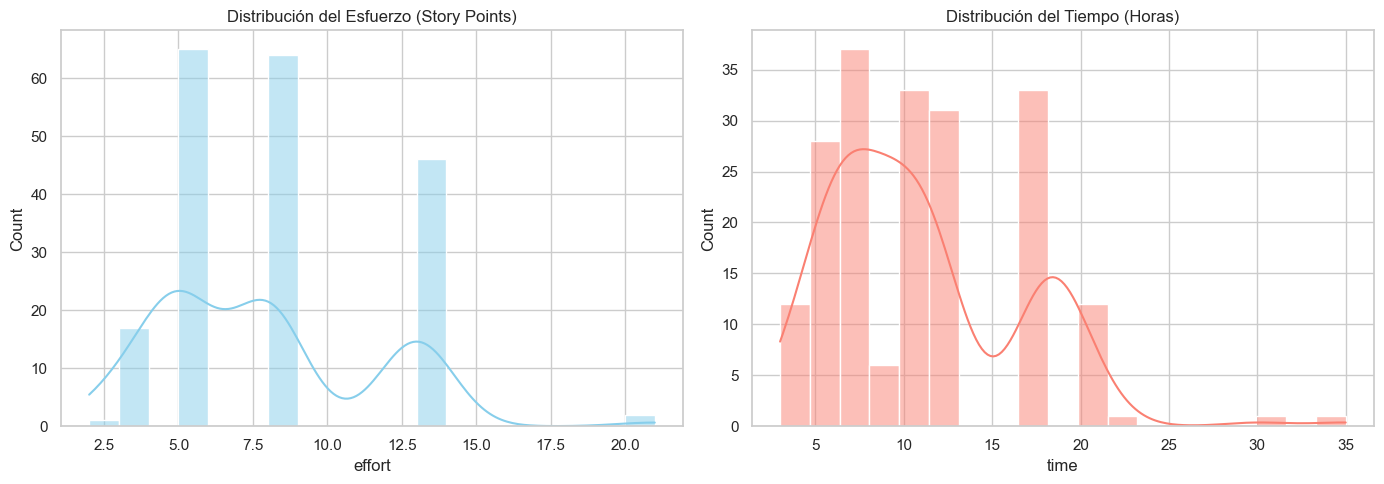

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['effort'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribución del Esfuerzo (Story Points)')

sns.histplot(df['time'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribución del Tiempo (Horas)')

plt.tight_layout()
plt.show()

## 3. Preparación de Datos y Feature Engineering

Aquí realizamos toda la preparación de datos, incluyendo la ingeniería de características que probamos anteriormente.

In [38]:
df['full_text'] = df['gherkin'] + " " + df['unit_tests']

def extract_features(df_to_feature):
    df_featured = df_to_feature.copy()
    # Características estructurales
    gherkin_keywords = ['Given', 'When', 'Then', 'And', 'Dado', 'Cuando', 'Entonces', 'Y']
    df_featured['gherkin_steps'] = df_featured['gherkin'].apply(lambda x: sum(x.count(word) for word in gherkin_keywords))
    df_featured['num_unit_tests'] = df_featured['unit_tests'].apply(lambda x: x.lower().count('def test_'))

    # Características temáticas/de dominio
    df_featured['has_frontend'] = df_featured['full_text'].str.contains('frontend|UI|interfaz|CSS|React|Angular|Vue', case=False).astype(int)
    df_featured['has_backend'] = df_featured['full_text'].str.contains('backend|servidor|database|base de datos|bd|API', case=False).astype(int)
    df_featured['has_security'] = df_featured['full_text'].str.contains('seguridad|security|JWT|OAuth|token|autenticación', case=False).astype(int)
    df_featured['has_performance'] = df_featured['full_text'].str.contains('performance|rendimiento|cache|optimización|índice|vistas materializadas', case=False).astype(int)
    df_featured['has_devops'] = df_featured['full_text'].str.contains('devops|CI/CD|Docker|pipeline|deployment|monitoreo', case=False).astype(int)
    df_featured['has_data_migration'] = df_featured['full_text'].str.contains('migración|migration|schema', case=False).astype(int)
    df_featured['has_payment'] = df_featured['full_text'].str.contains('pago|payment|stripe|paypal', case=False).astype(int)

    return df_featured

df_featured = extract_features(df)

y = df_featured[['effort', 'time']]

spanish_stop_words = [
    'de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'ha', 'sí', 'porque', 'esta', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'entre', 'ser', 'esa', 'estos', 'este', 'estoy'
]

vectorizer = TfidfVectorizer(stop_words=spanish_stop_words, max_features=500)
X_text_vectorized = vectorizer.fit_transform(df_featured['full_text'])


feature_columns = ['gherkin_steps', 'num_unit_tests', 'has_frontend', 'has_backend', 'has_security', 'has_performance', 'has_devops', 'has_data_migration', 'has_payment']
X_numerical_features = df_featured[feature_columns].values

X_base = X_text_vectorized # Modelo base solo con texto
X_improved = hstack([X_text_vectorized, X_numerical_features]).tocsr() # Modelo mejorado con más features

print("Preparación de datos completada.")

Preparación de datos completada.


## 4. Evaluación Robusta con Validación Cruzada (Cross-Validation)

En lugar de una única división de datos, la validación cruzada (con k=5) divide los datos 5 veces, entrenando y probando en diferentes subconjuntos. Esto nos da una medida mucho más fiable del rendimiento real del modelo, ya que reduce la aleatoriedad de una única división.

In [39]:
def evaluate_model_with_cv(X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores_effort = []
    mae_scores_time = []

    base_gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        model = MultiOutputRegressor(estimator=base_gb_model)
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        
        mae_fold = mean_absolute_error(y_val_fold, y_pred_fold, multioutput='raw_values')
        mae_scores_effort.append(mae_fold[0])
        mae_scores_time.append(mae_fold[1])
        
    return np.mean(mae_scores_effort), np.mean(mae_scores_time)

print("Evaluando Modelo Base (solo texto)...")
mae_effort_base, mae_time_base = evaluate_model_with_cv(X_base, y)
print(f"-> MAE Esfuerzo Promedio: {mae_effort_base:.2f} puntos")
print(f"-> MAE Tiempo Promedio: {mae_time_base:.2f} horas")

print("\nEvaluando Modelo Mejorado (con Feature Engineering)...")
mae_effort_improved, mae_time_improved = evaluate_model_with_cv(X_improved, y)
print(f"-> MAE Esfuerzo Promedio: {mae_effort_improved:.2f} puntos")
print(f"-> MAE Tiempo Promedio: {mae_time_improved:.2f} horas")

Evaluando Modelo Base (solo texto)...
-> MAE Esfuerzo Promedio: 1.53 puntos
-> MAE Tiempo Promedio: 2.15 horas

Evaluando Modelo Mejorado (con Feature Engineering)...
-> MAE Esfuerzo Promedio: 1.37 puntos
-> MAE Tiempo Promedio: 1.93 horas


## 5. Visualización de la Mejora

Un gráfico de barras es la forma más clara de visualizar si nuestras mejoras han tenido un impacto positivo (es decir, si han reducido el error).

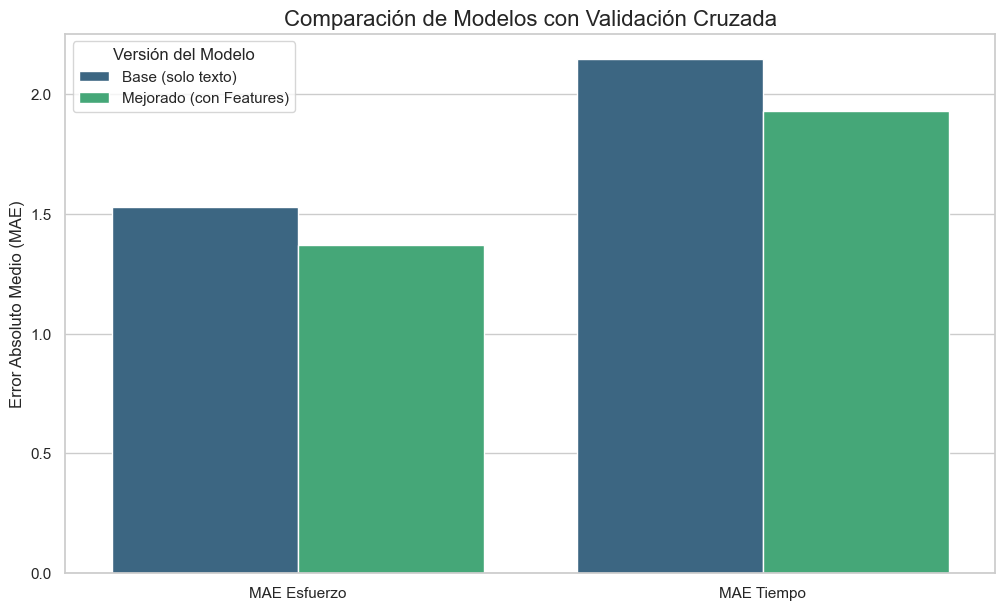

In [40]:
# Datos para el gráfico
results_data = {
    'Métrica': ['MAE Esfuerzo', 'MAE Esfuerzo', 'MAE Tiempo', 'MAE Tiempo'],
    'Modelo': ['Base (solo texto)', 'Mejorado (con Features)', 'Base (solo texto)', 'Mejorado (con Features)'],
    'Error Promedio': [mae_effort_base, mae_effort_improved, mae_time_base, mae_time_improved]
}
results_df = pd.DataFrame(results_data)

# Creación del gráfico
plt.figure(figsize=(12, 7))
barplot = sns.barplot(data=results_df, x='Métrica', y='Error Promedio', hue='Modelo', palette='viridis')

plt.title('Comparación de Modelos con Validación Cruzada', fontsize=16)
plt.ylabel('Error Absoluto Medio (MAE)')
plt.xlabel('')
plt.legend(title='Versión del Modelo')
plt.show()

## 6. Búsqueda de Hiperparámetros (Tuning)

Ahora que sabemos que el `GradientBoostingRegressor` con `Feature Engineering` es el mejor enfoque, vamos a optimizarlo encontrando la mejor combinación de hiperparámetros.

In [41]:
# Definir el espacio de búsqueda de parámetros
param_grid = {
    'estimator__n_estimators': [100, 150, 200], # Número de árboles
    'estimator__learning_rate': [0.05, 0.1],   # Tasa de aprendizaje
    'estimator__max_depth': [3, 4, 5]             # Profundidad máxima de cada árbol
}

# Modelo base sin entrenar
base_gb = GradientBoostingRegressor(random_state=42)
multi_output_model_for_tuning = MultiOutputRegressor(estimator=base_gb)

# Configurar GridSearchCV
# Usaremos 'neg_mean_absolute_error' como métrica, ya que GridSearchCV intenta maximizar. 
# Maximizar un MAE negativo es lo mismo que minimizar el MAE.
grid_search = GridSearchCV(
    estimator=multi_output_model_for_tuning,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5, # 5-fold cross-validation
    n_jobs=-1, # Usar todos los procesadores disponibles
    verbose=1
)

print("Iniciando búsqueda de hiperparámetros... Esto puede tardar unos minutos.")
grid_search.fit(X_improved, y)

print("\nBúsqueda completada.")
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

Iniciando búsqueda de hiperparámetros... Esto puede tardar unos minutos.
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Búsqueda completada.
Mejores parámetros encontrados:
{'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 200}


**Interpretación del Gráfico:**

Las barras más bajas indican un mejor rendimiento (menor error). Si las barras del 'Modelo Mejorado' son consistentemente más bajas que las del 'Modelo Base', podemos concluir con mayor confianza que nuestra ingeniería de características fue exitosa.

## 7. Conclusiones y Próximos Pasos

En este análisis, hemos:
1.  **Implementado Validación Cruzada** para obtener una métrica de error mucho más fiable.
2.  **Validado el impacto de la Ingeniería de Características**, demostrando que añadir más contexto al modelo reduce el error de predicción.
3.  **Realizado una búsqueda de Hiperparámetros**, para encontrar la configuración óptima para nuestro mejor modelo.
4.  **Visualizado los resultados**, lo que facilita la comunicación de los hallazgos.

**Próximos Pasos Recomendados:**

1.  **Actualizar `train_model.py`:** El script principal debe ser actualizado para usar `GradientBoostingRegressor` con los **mejores parámetros encontrados** por `GridSearchCV` y entrenarlo con **todos los datos**.
2.  **Aumentar el Dataset:** Sigue siendo el paso más importante para mejorar aún más la precisión.